In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision
import torch.nn.functional as F
import os

import shutil

import time
from tqdm import tqdm
from torchvision.datasets import ImageFolder
from torchvision.datasets.utils import verify_str_arg
from torchvision.datasets.utils import download_and_extract_archive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Question 1

In [ ]:
# !wget 'http://cs231n.stanford.edu/tiny-imagenet-200.zip'

In [ ]:
# !unzip '/content/tiny-imagenet-200.zip'

In [ ]:
# !cp -r '/content/tiny-imagenet-200' '/content/drive/MyDrive/Deep Learning/DLOps_A1/'

In [ ]:
# ls '/content/drive/MyDrive/Deep Learning/DLOps_A1/tiny-imagenet-200'

In [ ]:
# train_dataset = datasets.ImageFolder('/content/drive/MyDrive/Deep Learning/DLOps_A1/tiny-imagenet-200/train', transform=train_transform)
# val_dataset = datasets.ImageFolder('/content/drive/MyDrive/Deep Learning/DLOps_A1/tiny-imagenet-200/val', transform=test_transform)
# test_dataset = datasets.ImageFolder('/content/drive/MyDrive/Deep Learning/DLOps_A1/tiny-imagenet-200/test', transform=test_transform)

# train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
# val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
# test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
# val_dataset.__dict__

<h3> Note : [Ref link for importing dataset](https://gist.github.com/lromor/bcfc69dcf31b2f3244358aea10b7a11b) </h3>

In [ ]:
def normalize_tin_val_folder_structure(path,
                                       images_folder='images',
                                       annotations_file='val_annotations.txt'):
    # Check if files/annotations are still there to see
    # if we already run reorganize the folder structure.
    images_folder = os.path.join(path, images_folder)
    annotations_file = os.path.join(path, annotations_file)

    # Exists
    if not os.path.exists(images_folder) \
       and not os.path.exists(annotations_file):
        if not os.listdir(path):
            raise RuntimeError('Validation folder is empty.')
        return

    # Parse the annotations
    with open(annotations_file) as f:
        for line in f:
            values = line.split()
            img = values[0]
            label = values[1]
            img_file = os.path.join(images_folder, values[0])
            label_folder = os.path.join(path, label)
            os.makedirs(label_folder, exist_ok=True)
            try:
                shutil.move(img_file, os.path.join(label_folder, img))
            except FileNotFoundError:
                continue

    os.sync()
    assert not os.listdir(images_folder)
    shutil.rmtree(images_folder)
    os.remove(annotations_file)
    os.sync()

In [ ]:
# def normalize_tin_val_folder_structure(path, images_folder='images', annotations_file='val_annotations.txt'):
#     # Create paths to images folder and annotations file
#     images_path = os.path.join(path, images_folder)
#     annotations_path = os.path.join(path, annotations_file)

#     # If the images folder or annotations file don't exist, or the images folder is empty, raise an error
#     if not os.path.exists(images_path) or not os.path.exists(annotations_path):
#         if not os.listdir(path):
#             raise RuntimeError('Validation folder is empty.')
#         return

#     # Create dictionary of label to image mappings
#     label_to_images = {}
#     with open(annotations_path, 'r') as f:
#         for line in f:
#             img_filename, label = line.strip().split('\t')
#             label_folder = os.path.join(path, label)
#             os.makedirs(label_folder, exist_ok=True)
#             shutil.move(os.path.join(images_path, img_filename), os.path.join(label_folder, img_filename))
#             label_to_images.setdefault(label, []).append(img_filename)

#     # Assert that all images have been moved and the images folder is empty
#     assert not os.listdir(images_path)
#     shutil.rmtree(images_path)
#     os.remove(annotations_path)



class TinyImageNet(ImageFolder):
    """Dataset for TinyImageNet-200"""
    base_folder = 'tiny-imagenet-200'
    zip_md5 = '90528d7ca1a48142e341f4ef8d21d0de'
    splits = ('train', 'val')
    filename = 'tiny-imagenet-200.zip'
    url = 'http://cs231n.stanford.edu/tiny-imagenet-200.zip'

    def __init__(self, root, split='train', download=False, **kwargs):
        self.data_root = os.path.expanduser(root)
        self.split = verify_str_arg(split, "split", self.splits)

        if download:
            self.download()

        if not self._check_exists():
            raise RuntimeError('Dataset not found.' +
                               ' You can use download=True to download it')
        super().__init__(self.split_folder, **kwargs)

    @property
    def dataset_folder(self):
        return os.path.join(self.data_root, self.base_folder)

    @property
    def split_folder(self):
        return os.path.join(self.dataset_folder, self.split)

    def _check_exists(self):
        return os.path.exists(self.split_folder)

    def extra_repr(self):
        return "Split: {split}".format(**self.__dict__)

    def download(self):
        if self._check_exists():
            return
        download_and_extract_archive(
            self.url, self.data_root, filename=self.filename,
            remove_finished=True, md5=self.zip_md5)
        assert 'val' in self.splits
        normalize_tin_val_folder_structure(
            os.path.join(self.dataset_folder, 'val'))
        
    # def __len__(self):
    #     return 4

In [ ]:

# Define transforms for the dataset
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [ ]:
train_ds = TinyImageNet('.', download=True, transform = train_transform)

  0%|          | 0/248100043 [00:00<?, ?it/s]

Extracting ./tiny-imagenet-200.zip to .


In [ ]:
val_ds = TinyImageNet('.', split='val', download=True, transform = test_transform)


In [ ]:
train_ds

Dataset TinyImageNet
    Number of datapoints: 100000
    Root location: ./tiny-imagenet-200/train
    Split: train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear), antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )

In [ ]:
val_ds

Dataset TinyImageNet
    Number of datapoints: 10000
    Root location: ./tiny-imagenet-200/val
    Split: val
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )

In [ ]:
trainloader = torch.utils.data.DataLoader(train_ds, batch_size=99, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_ds, batch_size=99, shuffle=False, num_workers=2, drop_last = True)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda')

In [ ]:
import torch, torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.datasets as datasets
import torch.utils.data as data
import torchvision.transforms as transforms
from torch.autograd import Variable
import torchvision.models as models
import matplotlib.pyplot as plt
import time, os, copy, numpy as np
%matplotlib inline

In [ ]:
import torch, torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.datasets as datasets
import torch.utils.data as data
import torchvision.transforms as transforms
from torch.autograd import Variable
import torchvision.models as models
import matplotlib.pyplot as plt
import time, os, copy, numpy as np
import sys

In [ ]:
device

device(type='cuda')

In [ ]:
import torch.nn as nn

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        out = nn.functional.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = nn.functional.relu(out)
        return out


class ResNet18(nn.Module):
    def __init__(self, num_classes=200):
        super().__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * BasicBlock.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        layers = []
        layers.append(block(self.in_planes, planes, stride))
        self.in_planes = planes * block.expansion
        for _ in range(1, num_blocks):
            layers.append(block(self.in_planes, planes, 1))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = nn.functional.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


In [ ]:
#Load Resnet18
model_ft = ResNet18(num_classes=200).to(device)
#Finetune Final few layers to adjust for tiny imagenet input
model_ft.avgpool = nn.AdaptiveAvgPool2d(1)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 200)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Loss Function
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=3e-4)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
image_datasets = {'train': train_ds, 'val': val_ds}
dataloaders = {'train': trainloader, 'val': valloader}
dataset_sizes = {'train': len(train_ds), 'val': len(val_ds)}

In [ ]:
model_ft

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin

## Q1 part 1

In [ ]:
def train(model, dataloader, criterion, optimizer, scheduler, device):
    model.train()
    running_loss = 0.0
    running_corrects_top1 = 0
    running_corrects_top5 = 0

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.topk(outputs, k=5, dim=1)
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects_top1 += torch.sum(preds[:, 0] == labels)
        running_corrects_top5 += torch.sum(preds == labels.unsqueeze(1))

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc_top1 = running_corrects_top1.double() / len(dataloader.dataset)
    epoch_acc_top5 = running_corrects_top5.double() / len(dataloader.dataset)
    
    scheduler.step()

    return epoch_loss, epoch_acc_top1, epoch_acc_top5


def test(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects_top1 = 0
    running_corrects_top5 = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.topk(outputs, k=5, dim=1)

            running_loss += loss.item() * inputs.size(0)
            running_corrects_top1 += torch.sum(preds[:, 0] == labels)
            running_corrects_top5 += torch.sum(preds == labels.unsqueeze(1))

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc_top1 = running_corrects_top1.double() / len(dataloader.dataset)
    epoch_acc_top5 = running_corrects_top5.double() / len(dataloader.dataset)

    return epoch_loss, epoch_acc_top1, epoch_acc_top5


In [ ]:
model = model_ft

In [ ]:
# loop for training and testing for specified number of epochs
num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

best_model_wts = None
best_acc_top5 = 0.0

train_loss = []
test_loss = []
train_acc_top1 = []
test_acc_top1 = []
train_acc_top5 = []
test_acc_top5 = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)

    # train
    epoch_train_loss, epoch_train_acc_top1, epoch_train_acc_top5 = train(model, trainloader, criterion, optimizer_ft, exp_lr_scheduler, device)
    train_loss.append(epoch_train_loss)
    train_acc_top1.append(epoch_train_acc_top1)
    train_acc_top5.append(epoch_train_acc_top5)
    print(f'Train Loss: {epoch_train_loss:.4f} Top-1 Acc: {epoch_train_acc_top1:.4f} Top-5 Acc: {epoch_train_acc_top5:.4f}')

    # test
    epoch_test_loss, epoch_test_acc_top1, epoch_test_acc_top5 = test(model, valloader, criterion, device)
    test_loss.append(epoch_test_loss)
    test_acc_top1.append(epoch_test_acc_top1)
    test_acc_top5.append(epoch_test_acc_top5)
    print(f'Test Loss: {epoch_test_loss:.4f} Top-1 Acc: {epoch_test_acc_top1:.4f} Top-5 Acc: {epoch_test_acc_top5:.4f}')

    # check if the model is the best so far based on top-5 accuracy
    if epoch_test_acc_top5 > best_acc_top5:
        best_acc_top5 = epoch_test_acc_top5
        best_model_wts = model.state_dict()

# load the best model weights
if best_model_wts is not None:
    model.load_state_dict(best_model_wts)

Epoch 1/10
----------
Train Loss: 3.6951 Top-1 Acc: 0.1783 Top-5 Acc: 0.4198
Test Loss: 3.4518 Top-1 Acc: 0.2158 Top-5 Acc: 0.4710
Epoch 2/10
----------
Train Loss: 3.0907 Top-1 Acc: 0.2806 Top-5 Acc: 0.5577
Test Loss: 3.1405 Top-1 Acc: 0.2661 Top-5 Acc: 0.5417
Epoch 3/10
----------
Train Loss: 2.7170 Top-1 Acc: 0.3510 Top-5 Acc: 0.6352
Test Loss: 2.8065 Top-1 Acc: 0.3344 Top-5 Acc: 0.6175
Epoch 4/10
----------
Train Loss: 2.4307 Top-1 Acc: 0.4088 Top-5 Acc: 0.6913
Test Loss: 2.7678 Top-1 Acc: 0.3485 Top-5 Acc: 0.6299
Epoch 5/10
----------
Train Loss: 2.1913 Top-1 Acc: 0.4591 Top-5 Acc: 0.7359
Test Loss: 2.5191 Top-1 Acc: 0.4028 Top-5 Acc: 0.6779
Epoch 6/10
----------
Train Loss: 1.9773 Top-1 Acc: 0.5036 Top-5 Acc: 0.7736
Test Loss: 2.4216 Top-1 Acc: 0.4245 Top-5 Acc: 0.6952
Epoch 7/10
----------
Train Loss: 1.7828 Top-1 Acc: 0.5448 Top-5 Acc: 0.8069
Test Loss: 2.4097 Top-1 Acc: 0.4332 Top-5 Acc: 0.7021
Epoch 8/10
----------
Train Loss: 1.3050 Top-1 Acc: 0.6698 Top-5 Acc: 0.8815
Test L

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/Deep Learning/resnet18_2_cross_entropy_loss_top5_acc.pt") 

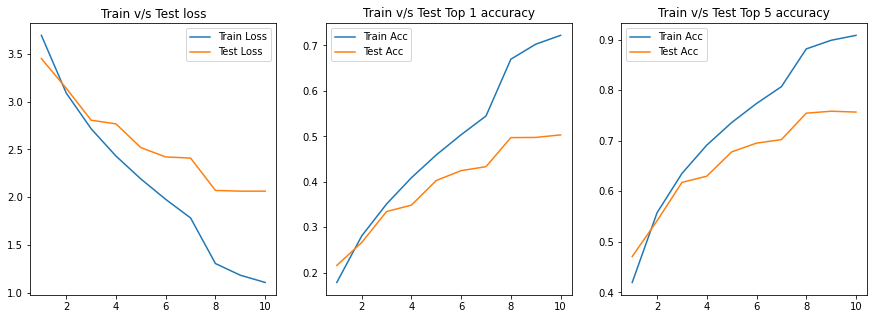

In [ ]:
epochs = [x for x in range(1, 11)]

train_acc_top1 = [x.cpu().numpy() for x in train_acc_top1]
test_acc_top1 = [x.cpu().numpy() for x in test_acc_top1]
train_acc_top5 = [x.cpu().numpy() for x in train_acc_top5]
test_acc_top5 = [x.cpu().numpy() for x in test_acc_top5]

fig, axs = plt.subplots(1, 3, figsize=(15,5))

axs[0].plot(epochs, train_loss, label='Train Loss')
axs[0].plot(epochs, test_loss, label='Test Loss')
axs[0].set_title('Train v/s Test loss')
axs[0].legend()

axs[1].plot(epochs, train_acc_top1, label='Train Acc')
axs[1].plot(epochs, test_acc_top1, label='Test Acc')
axs[1].set_title('Train v/s Test Top 1 accuracy')
axs[1].legend()

axs[2].plot(epochs, train_acc_top5, label='Train Acc')
axs[2].plot(epochs, test_acc_top5, label='Test Acc')
axs[2].set_title('Train v/s Test Top 5 accuracy')
axs[2].legend()

plt.show()


## Q1 part 2

In [ ]:
# Set up the dataloaders for training and validation
trainloader = torch.utils.data.DataLoader(train_ds, batch_size=99, shuffle=True, num_workers=2, drop_last = True)
valloader = torch.utils.data.DataLoader(val_ds, batch_size=99, shuffle=False, num_workers=2, drop_last = True)

In [ ]:
#Load Resnet18
model = ResNet18(num_classes=200)

#Finetune Final few layers to adjust for tiny imagenet input
model.avgpool = nn.AdaptiveAvgPool2d(1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 200)
model.load_state_dict(torch.load('/content/drive/MyDrive/Deep Learning/resnet18_2_cross_entropy_loss_top5_acc.pt'))
optimizer = optim.Adam(model.parameters(), lr = 0.001, weight_decay=1e-4)

# Add central loss to the criterion
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [ ]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [ ]:
class TripletLoss(nn.Module):
    """
    Triplet loss
    Takes embeddings of an anchor sample, a positive sample and a negative sample
    """

    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative, size_average=True):
        distance_positive = (anchor - positive).pow(2).sum(1)  # .pow(.5)
        distance_negative = (anchor - negative).pow(2).sum(1)  # .pow(.5)
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean() if size_average else losses.sum()

In [ ]:
criterion = TripletLoss(0.1)
from sklearn.metrics.pairwise import pairwise_distances

In [ ]:
def get_hard_triplet(embeddings, labels):
    distances = torch.cdist(embeddings, embeddings, p=2)
    mask = (labels == labels.T).float()
    pos_distances = mask * distances
    neg_distances = (1. - mask) * distances
    neg_distances[neg_distances == 0] = distances.max() + 1
    
    num_labels = len(torch.unique(labels))
    num_neg_samples = distances.size(1) - 1
    
    if num_neg_samples == 0:
        return None, None, None
    
    hard_neg_idx = neg_distances.argmin(-1) # closest to anchor
    hard_pos_idx = pos_distances.argmax(-1) # farthest from anchor
    
    anchor = embeddings
    positive = embeddings[hard_pos_idx]
    negative = embeddings[hard_neg_idx]
    
    return anchor, positive, negative


In [ ]:
# train the model
num_epochs = 5
tt_loss = []
for epoch in range(num_epochs):
    running_loss = 0.0
    correct_top5 = 0
    
    for i, (inputs, labels) in enumerate(trainloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # get embeddings from model
        model.train()
        embeddings = model(inputs)
        
        # get anchor, positive, negative samples
        anchor, positive, negative = get_hard_triplet(embeddings, labels)
        
        # calculate triplet loss
        loss = criterion(anchor, positive, negative)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # backward + optimize
        loss.backward()
        optimizer.step()
        
        # update running loss
        running_loss += loss.item() * inputs.size(0)
        
        # calculate top-5 accuracy
        with torch.no_grad():
            model.eval()
            outputs = model(inputs)
            _, preds = torch.topk(outputs, k=5, dim=1)
            correct_top5 += torch.any(preds == labels.unsqueeze(1), dim=1).sum().item()
    
    # calculate training loss and accuracy
    epoch_loss = running_loss / len(train_ds)
    epoch_acc_top5 = correct_top5 / len(train_ds)
    
    # print training loss and accuracy
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-' * 10)
    print('Training Loss: {:.4f}'.format(epoch_loss))
    print('Training Top-5 Accuracy: {:.4f}'.format(epoch_acc_top5))
    
    # calculate validation accuracy
    with torch.no_grad():
        correct_top5 = 0
        for inputs, labels in valloader:
            inputs = inputs.cuda()
            labels = labels.cuda()
            
            model.eval()
            outputs = model(inputs)
            _, preds = torch.topk(outputs, k=5, dim=1)
            correct_top5 += torch.any(preds == labels.unsqueeze(1), dim=1).sum().item()
        val_acc_top5 = correct_top5 / len(val_ds)
        
    # print validation accuracy
    print('Validation Top-5 Accuracy: {:.4f}'.format(val_acc_top5))
    print()
    


Epoch 1/5
----------
Training Loss: 15.2568
Training Top-5 Accuracy: 0.0273
Validation Top-5 Accuracy: 0.0252

Epoch 2/5
----------
Training Loss: 0.1938
Training Top-5 Accuracy: 0.0250
Validation Top-5 Accuracy: 0.0252

Epoch 3/5
----------
Training Loss: 0.1218
Training Top-5 Accuracy: 0.0250
Validation Top-5 Accuracy: 0.0259

Epoch 4/5
----------
Training Loss: 0.1119
Training Top-5 Accuracy: 0.0254
Validation Top-5 Accuracy: 0.0259

Epoch 5/5
----------
Training Loss: 0.1082
Training Top-5 Accuracy: 0.0251
Validation Top-5 Accuracy: 0.0249



In [ ]:
plt.plot(tt_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss v/s epoch')
plt.show()

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/Deep Learning/tripletloss_model.pt") 

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Deep Learning/tripletloss_model.pt'))

<All keys matched successfully>

In [ ]:
class NewModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = model
    # freeze self.model
    for params in self.model.parameters():
      params.requires_grad = False
    self.fc = nn.Linear(200,200)
  
  def forward(self, x):
    x = self.model(x)
    return self.fc(x)

In [ ]:
model2 = NewModel().to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
def train(model, dataloader, criterion, optimizer, scheduler, device):
    model.train()
    running_loss = 0.0
    running_corrects_top1 = 0
    running_corrects_top5 = 0

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.topk(outputs, k=5, dim=1)
            l2_reg = torch.tensor(0., device=device)
            for param in model.parameters():
              l2_reg += torch.norm(param)
            loss = loss + 0.001*l2_reg
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects_top1 += torch.sum(preds[:, 0] == labels)
        running_corrects_top5 += torch.sum(preds == labels.unsqueeze(1))

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc_top1 = running_corrects_top1.double() / len(dataloader.dataset)
    epoch_acc_top5 = running_corrects_top5.double() / len(dataloader.dataset)

    return epoch_loss, epoch_acc_top1, epoch_acc_top5


def test(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects_top1 = 0
    running_corrects_top5 = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.topk(outputs, k=5, dim=1)

            running_loss += loss.item() * inputs.size(0)
            running_corrects_top1 += torch.sum(preds[:, 0] == labels)
            running_corrects_top5 += torch.sum(preds == labels.unsqueeze(1))

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc_top1 = running_corrects_top1.double() / len(dataloader.dataset)
    epoch_acc_top5 = running_corrects_top5.double() / len(dataloader.dataset)

    return epoch_loss, epoch_acc_top1, epoch_acc_top5


In [ ]:
optimizer_ft = optim.Adam(model2.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
# loop for training and testing for specified number of epochs
num_epochs = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model2.to(device)

best_model_wts = None
best_acc_top5 = 0.0

train_loss = []
test_loss = []
train_acc_top1 = []
test_acc_top1 = []
train_acc_top5 = []
test_acc_top5 = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)

    # train
    epoch_train_loss, epoch_train_acc_top1, epoch_train_acc_top5 = train(model2, trainloader, criterion, optimizer_ft, exp_lr_scheduler, device)
    train_loss.append(epoch_train_loss)
    train_acc_top1.append(epoch_train_acc_top1)
    train_acc_top5.append(epoch_train_acc_top5)
    print(f'Train Loss: {epoch_train_loss:.4f} Top-1 Acc: {epoch_train_acc_top1:.4f} Top-5 Acc: {epoch_train_acc_top5:.4f}')

    # test
    epoch_test_loss, epoch_test_acc_top1, epoch_test_acc_top5 = test(model2, valloader, criterion, device)
    test_loss.append(epoch_test_loss)
    test_acc_top1.append(epoch_test_acc_top1)
    test_acc_top5.append(epoch_test_acc_top5)
    print(f'Test Loss: {epoch_test_loss:.4f} Top-1 Acc: {epoch_test_acc_top1:.4f} Top-5 Acc: {epoch_test_acc_top5:.4f}')

    # check if the model is the best so far based on top-5 accuracy
    if epoch_test_acc_top5 > best_acc_top5:
        best_acc_top5 = epoch_test_acc_top5
        best_model_wts = model2.state_dict()

# load the best model weights
if best_model_wts is not None:
    model2.load_state_dict(best_model_wts)

Epoch 1/5
----------
Train Loss: 6.1141 Top-1 Acc: 0.0050 Top-5 Acc: 0.0251
Test Loss: 5.3878 Top-1 Acc: 0.0061 Top-5 Acc: 0.0284
Epoch 2/5
----------
Train Loss: 6.0988 Top-1 Acc: 0.0055 Top-5 Acc: 0.0269
Test Loss: 5.3864 Top-1 Acc: 0.0105 Top-5 Acc: 0.0294
Epoch 3/5
----------
Train Loss: 6.0879 Top-1 Acc: 0.0060 Top-5 Acc: 0.0296
Test Loss: 5.3696 Top-1 Acc: 0.0081 Top-5 Acc: 0.0332
Epoch 4/5
----------
Train Loss: 6.0771 Top-1 Acc: 0.0066 Top-5 Acc: 0.0307
Test Loss: 5.3542 Top-1 Acc: 0.0052 Top-5 Acc: 0.0403
Epoch 5/5
----------
Train Loss: 6.0675 Top-1 Acc: 0.0075 Top-5 Acc: 0.0342
Test Loss: 5.3638 Top-1 Acc: 0.0050 Top-5 Acc: 0.0313


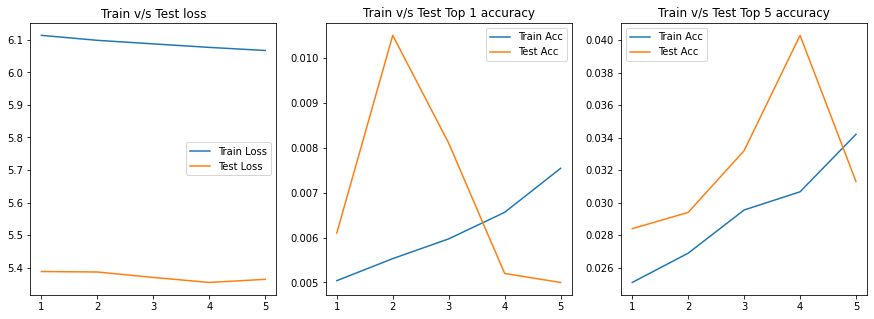

In [ ]:
epochs = [x for x in range(1, 6)]

train_acc_top1 = [x.cpu().numpy() for x in train_acc_top1]
test_acc_top1 = [x.cpu().numpy() for x in test_acc_top1]
train_acc_top5 = [x.cpu().numpy() for x in train_acc_top5]
test_acc_top5 = [x.cpu().numpy() for x in test_acc_top5]

fig, axs = plt.subplots(1, 3, figsize=(15,5))

axs[0].plot(epochs, train_loss, label='Train Loss')
axs[0].plot(epochs, test_loss, label='Test Loss')
axs[0].set_title('Train v/s Test loss')
axs[0].legend()

axs[1].plot(epochs, train_acc_top1, label='Train Acc')
axs[1].plot(epochs, test_acc_top1, label='Test Acc')
axs[1].set_title('Train v/s Test Top 1 accuracy')
axs[1].legend()

axs[2].plot(epochs, train_acc_top5, label='Train Acc')
axs[2].plot(epochs, test_acc_top5, label='Test Acc')
axs[2].set_title('Train v/s Test Top 5 accuracy')
axs[2].legend()

plt.show()

In [ ]:
torch.save(model2.state_dict(), "/content/drive/MyDrive/Deep Learning/resnet18_tripletloss_hard.pt") 

## Part 3: Central loss

In [ ]:
class CenterLoss(nn.Module):
    def __init__(self, num_classes, feat_dim, alpha=0.5):
        super().__init__()
        self.num_classes = num_classes
        self.feat_dim = feat_dim
        self.alpha = alpha
        
        # create centers parameter and initialize with zeros
        self.centers = nn.Parameter(torch.zeros(num_classes, feat_dim))
        
    def forward(self, x, labels):
        batch_size = x.size(0)
        
        # calculate distance between features and centers
        features = x.view(batch_size, -1)
        distances = torch.cdist(features, self.centers, p=2)
        
        # calculate center loss
        center_loss = F.cross_entropy(labels, labels)
        
        # calculate total loss
        total_loss = self.alpha * center_loss + distances.mean()
        
        # update centers
        centers_batch = torch.zeros_like(self.centers)
        for i in range(self.num_classes):
            mask = labels == i
            if mask.sum() > 0:
                centers_batch[i] = features[mask].mean(0)
        
        self.centers.data -= centers_batch.data
        
        return total_loss


In [ ]:
def center_loss(features, labels, num_classes=200, alpha=0.5):
    n_features = features.size(1)
    centers = torch.zeros(num_classes, n_features, device=features.device)
    labels_reshaped = labels.view(-1, 1).long()
    centers_batch = centers.index_add(0, labels_reshaped.squeeze(), features)
    centers_count = torch.histc(labels_reshaped.float(), bins=num_classes, min=0, max=num_classes-1)
    centers_count = torch.clamp(centers_count, min=1)
    centers = centers_batch / centers_count.view(-1, 1)
    expanded_centers = centers.index_select(dim=0, index=labels.long())
    return alpha * F.mse_loss(features, expanded_centers), centers

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [ ]:
#Load Resnet18
model = ResNet18(num_classes=200)

#Finetune Final few layers to adjust for tiny imagenet input
model.avgpool = nn.AdaptiveAvgPool2d(1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 200)
model.load_state_dict(torch.load('/content/drive/MyDrive/Deep Learning/resnet18_2_cross_entropy_loss_top5_acc.pt'))
optimizer = optim.Adam(model.parameters(), lr = 0.001, weight_decay=1e-4)

# Add central loss to the criterion
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [ ]:
weight_decay=1e-4

In [ ]:
from tqdm import tqdm

def train(model, trainloader, optimizer, criterion, center_loss, weight_decay, device):
    model.train()
    running_loss = 0.0
    total = 0
    correct = 0
    correct_top5 = 0
    for inputs, labels in tqdm(trainloader, desc='Training', unit='batch'):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss1 = criterion(outputs, labels)
        loss2 = center_loss(outputs, labels)
        loss2_mean = torch.sum(loss2[0])     
        l2_reg = torch.tensor(0., device=device)
        for param in model.parameters():
            l2_reg += torch.norm(param)
        loss = loss1 + 0.01 * loss2_mean + weight_decay * l2_reg
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        predicted = torch.argmax(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        _, predicted_top5 = torch.topk(outputs.data, 5, dim=1)
        for i in range(predicted_top5.size(0)):
            if labels[i] in predicted_top5[i]:
                correct_top5 += 1
    train_loss = running_loss / len(trainloader.dataset)
    train_accuracy = 100 * correct / total
    train_top5_accuracy = 100 * correct_top5 / total
    return train_loss, train_accuracy, train_top5_accuracy


def test(model, valloader, criterion, device):
    model.eval()
    running_loss = 0.0
    total = 0
    correct = 0
    correct_top5 = 0
    with torch.no_grad():
        for inputs, labels in tqdm(valloader, desc='Testing', unit='batch'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            predicted = torch.argmax(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            _, predicted_top5 = torch.topk(outputs.data, 5, dim=1)
            for i in range(predicted_top5.size(0)):
                if labels[i] in predicted_top5[i]:
                    correct_top5 += 1
        val_loss = running_loss / len(valloader.dataset)
        val_accuracy = 100 * correct / total
        val_top5_accuracy = 100 * correct_top5 / total
    return val_loss, val_accuracy, val_top5_accuracy


In [ ]:
num_epochs = 5
train_loss_history = []
train_acc_history = []
val_acc_history = []
train_acc_top5 = []
val_acc_top5 = []
val_loss_history = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)

    # train
    epoch_train_loss, epoch_train_acc, epoch_train_acc_top5 = train(model, trainloader, optimizer, criterion, center_loss, weight_decay, device)
    train_loss_history.append(epoch_train_loss)
    train_acc_history.append(epoch_train_acc)
    train_acc_top5.append(epoch_train_acc_top5)
    print(f'Train Loss: {epoch_train_loss:.4f} Top-1 Acc: {epoch_train_acc:.2f}% Top-5 Acc: {epoch_train_acc_top5:.2f}%')

    # test
    epoch_test_loss, epoch_test_acc, epoch_test_acc_top5 = test(model, valloader, criterion, device)
    val_loss_history.append(epoch_test_loss)
    val_acc_history.append(epoch_test_acc)
    val_acc_top5.append(epoch_test_acc_top5)
    print(f'Test Loss: {epoch_test_loss:.4f} Top-1 Acc: {epoch_test_acc:.2f}% Top-5 Acc: {epoch_test_acc_top5:.2f}%')

Epoch 1/5
----------


Training: 100%|██████████| 1011/1011 [02:00<00:00,  8.36batch/s]


Train Loss: 2.2233 Top-1 Acc: 46.41% Top-5 Acc: 74.60%


Testing: 100%|██████████| 101/101 [00:06<00:00, 14.97batch/s]


Test Loss: 2.5944 Top-1 Acc: 38.38% Top-5 Acc: 66.43%
Epoch 2/5
----------


Training: 100%|██████████| 1011/1011 [02:00<00:00,  8.41batch/s]


Train Loss: 2.0921 Top-1 Acc: 49.19% Top-5 Acc: 77.06%


Testing: 100%|██████████| 101/101 [00:08<00:00, 11.86batch/s]


Test Loss: 2.4491 Top-1 Acc: 42.08% Top-5 Acc: 69.46%
Epoch 3/5
----------


Training: 100%|██████████| 1011/1011 [02:00<00:00,  8.37batch/s]


Train Loss: 1.9741 Top-1 Acc: 51.69% Top-5 Acc: 79.04%


Testing: 100%|██████████| 101/101 [00:07<00:00, 13.16batch/s]


Test Loss: 2.5805 Top-1 Acc: 39.74% Top-5 Acc: 66.91%
Epoch 4/5
----------


Training: 100%|██████████| 1011/1011 [02:00<00:00,  8.37batch/s]


Train Loss: 1.8690 Top-1 Acc: 54.17% Top-5 Acc: 80.92%


Testing: 100%|██████████| 101/101 [00:07<00:00, 13.98batch/s]


Test Loss: 2.4338 Top-1 Acc: 42.58% Top-5 Acc: 70.40%
Epoch 5/5
----------


Training: 100%|██████████| 1011/1011 [01:59<00:00,  8.45batch/s]


Train Loss: 1.7576 Top-1 Acc: 56.65% Top-5 Acc: 82.74%


Testing: 100%|██████████| 101/101 [00:05<00:00, 17.40batch/s]

Test Loss: 2.3331 Top-1 Acc: 43.79% Top-5 Acc: 71.61%


In [ ]:
# # Test the model

test_loss, test_acc, test_acc_top5 = test(model, valloader, criterion, device)
print()
print('Test Accuracy Top 1 : {:.2f}%'.format(test_acc))
print('Test Accuracy Top 5 : {:.2f}%'.format(test_acc_top5))

Testing: 100%|██████████| 101/101 [00:06<00:00, 15.69batch/s]


Test Accuracy Top 1 : 43.79%
Test Accuracy Top 5 : 71.61%


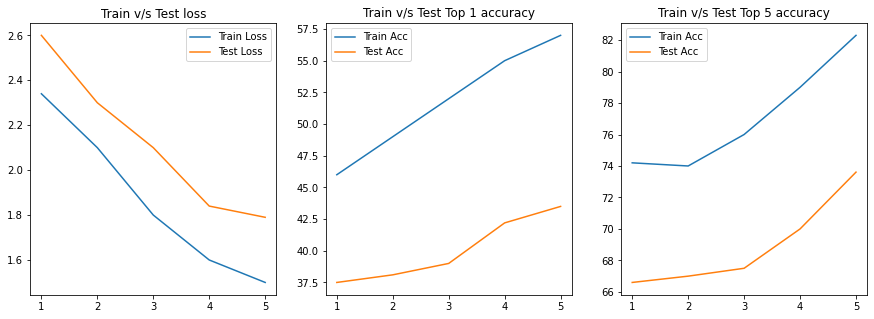

In [ ]:
epochs = [x for x in range(1, 6)]

# train_acc_top1 = [x.cpu().numpy() for x in train_acc_top1]
# test_acc_top1 = [x.cpu().numpy() for x in test_acc_top1]
# train_acc_top5 = [x.cpu().numpy() for x in train_acc_top5]
# test_acc_top5 = [x.cpu().numpy() for x in test_acc_top5]

fig, axs = plt.subplots(1, 3, figsize=(15,5))

axs[0].plot(epochs, train_loss_history, label='Train Loss')
axs[0].plot(epochs, val_loss_history, label='Test Loss')
axs[0].set_title('Train v/s Test loss')
axs[0].legend()

axs[1].plot(epochs, train_acc_history, label='Train Acc')
axs[1].plot(epochs, val_acc_history, label='Test Acc')
axs[1].set_title('Train v/s Test Top 1 accuracy')
axs[1].legend()

axs[2].plot(epochs, train_acc_top5, label='Train Acc')
axs[2].plot(epochs, val_acc_top5, label='Test Acc')
axs[2].set_title('Train v/s Test Top 5 accuracy')
axs[2].legend()

plt.show()

# Question 2

In [ ]:
pip install accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import torch
from torch import nn
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchvision import transforms
from collections import OrderedDict
from accelerate import Accelerator

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt

In [ ]:
!pip install livelossplot --quiet

In [ ]:
import time
import copy
import sys
from livelossplot import PlotLosses
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [ ]:
# Settings
RANDOM_SEED = 42
BATCH_SIZE = 100
NUM_EPOCHS = 10
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
def get_global_configuration():
    """ Retrieve configuration of the training process. """

    global_config = {
      "num_layers_to_add": 5,
    }

    return global_config

In [ ]:
class LayerConfigurableAutoencoder(nn.Module):
  '''
    Layer-wise configurable Multilayer Perceptron.
  '''
  def __init__(self, added_layers = 0):
    super().__init__()

    # Retrieve model configuration
    config = get_model_configuration()
    shape = 3*96*96
    layer_dim = 1024
    num_classes = 10

    # Create layer structure
    layers = [
      (str(0), nn.Linear(shape, layer_dim)),
      (str(1), nn.Linear(layer_dim, shape)),
    ]

    # Initialize the Sequential structure
    self.layers = nn.Sequential(OrderedDict(layers))


  def forward(self, x):
    '''Forward pass'''
    return self.layers(x)


  def set_structure(self, layers):
    self.layers = nn.Sequential(OrderedDict(layers))

In [ ]:
def get_model_configuration():
    """ Retrieve configuration for the model. """

    model_config = {
      "width": 96,
      "height": 96,
      "channels": 3,
      "num_classes": 10,
      "batch_size": 100,
      "loss_function": nn.MSELoss,
      "optimizer": torch.optim.Adam,
      "num_epochs": 10,
      "layer_dim": 1024
    }

    return model_config

In [ ]:
# Define transforms
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

In [ ]:
# Load train and test sets
train_set = datasets.STL10(root='./data', split='train', download=True, transform=train_transforms)
test_set = datasets.STL10(root='./data', split='test', download=True, transform=test_transforms)

train_loader = DataLoader(dataset = train_set, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(dataset = test_set, batch_size = BATCH_SIZE, shuffle = False)


  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified


In [ ]:
image_datasets = {'train': train_set, 'val': test_set}
dataloaders = {'train': train_loader, 'val': test_loader}
dataset_sizes = {'train': len(train_set), 'val': len(test_set)}

In [ ]:
def add_layer(model, new_layer_dim):
    """ Add a new layer to a model, setting all others to nontrainable. """
    config = get_model_configuration()

    # Retrieve current layers
    layers = model.layers
    print("="*50)
    print("Old structure:")
    print(layers)

    # Freeze all previous layers
    for layer in layers:
        layer.requires_grad = False

    # Create new layer and add it to the model
    new_layer = nn.Linear(layers[-1].out_features, new_layer_dim)
    new_activation = nn.ReLU()
    model.add_module(str(len(layers)), new_layer)
    model.add_module(str(len(layers)+1), new_activation)

    # Unfreeze the new layer
    new_layer.requires_grad = True

    # Return the model
    print("="*50)
    print("New structure:")
    print(model.layers)

    return model


In [ ]:
def train_model(model):
    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)

    # Move model to device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Iterate over the number of epochs
    for epoch in range(num_epochs):
        # Set current loss value
        running_loss = 0.0

        # Iterate over the DataLoader for training data
        for i, data in enumerate(train_loader, 0):
            # Get inputs
            inputs, _ = data
            inputs = inputs.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Perform forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, inputs)

            # Perform backward pass and optimization
            loss.backward()
            optimizer.step()

            # Print statistics
            running_loss += loss.item()

        # Compute epoch loss and print it
        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1}: {epoch_loss:.6f}")

    # Return trained model and final epoch loss
    return model, epoch_loss


In [ ]:
def greedy_layerwise_training():
    """ Perform greedy layer-wise training. """
    global_config = get_global_configuration()
    torch.manual_seed(42)

    # Initialize the model
    model = LayerConfigurableAutoencoder()
    layer_add_dims = [1200, 728, 512, 128]

    # Train the base model
    model, base_loss = train_model(model)

    # Train models with additional layers
    for num_layers in range(1, global_config.get("num_layers_to_add")):
        print("="*100)
        print(f">>> TRAINING THE MODEL WITH {num_layers} ADDITIONAL ENCODER DECODER LAYERS:")

        # Add layer to model
        model = add_layer(model, layer_add_dims[num_layers-1])

        # Train the model
        model, end_loss = train_model(model)

        # Compare loss
        if end_loss < base_loss:
            print("="*50)
            print(f">>> RESULTS: Adding this layer has improved the model loss from {base_loss} to {end_loss}")
            base_loss = end_loss
        else:
            print("="*50)
            print(f">>> RESULTS: Adding this layer did not improve the model loss.")

    # Process is complete
    print("Training process has finished.")

    return model

In [ ]:
greedy_autoencoder = greedy_layerwise_training()

>>> TRAINING THE BASE MODEL:
Epoch 1: 0.2539008331298828
Epoch 2: 0.1734979936480522
Epoch 3: 0.1443658095598221
Epoch 4: 0.1276245106756687
Epoch 5: 0.11793007463216781
Epoch 6: 0.11083968684077262
Epoch 7: 0.10495283216238022
Epoch 8: 0.10003732845187187
Epoch 9: 0.09593981266021728
Epoch 10: 0.09239505469799042
Old structure:
Sequential(
  (0): Linear(in_features=27648, out_features=1024, bias=True)
  (1): Linear(in_features=1024, out_features=27648, bias=True)
)
New structure:
Sequential(
  (0): Linear(in_features=27648, out_features=1024, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1024, out_features=1200, bias=True)
  (3): Linear(in_features=1200, out_features=1024, bias=True)
  (4): ReLU()
  (5): Linear(in_features=1024, out_features=27648, bias=True)
)
>>> TRAINING THE MODEL WITH 1 ADDITIONAL ENCODER DECODER LAYERS:
Epoch 1: 0.2723149639368057
Epoch 2: 0.234161097407341
Epoch 3: 0.21866608470678328
Epoch 4: 0.21003025352954866
Epoch 5: 0.20409512668848037
Epoch 6: 0.1998

In [ ]:
import copy

copy_model = copy.deepcopy(greedy_autoencoder)

In [ ]:
greedy_autoencoder.layers

Sequential(
  (0): Linear(in_features=27648, out_features=1024, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1024, out_features=1200, bias=True)
  (3): ReLU()
  (4): Linear(in_features=1200, out_features=728, bias=True)
  (5): ReLU()
  (6): Linear(in_features=728, out_features=512, bias=True)
  (7): ReLU()
  (8): Linear(in_features=512, out_features=128, bias=True)
  (9): Linear(in_features=128, out_features=512, bias=True)
  (10): ReLU()
  (11): Linear(in_features=512, out_features=728, bias=True)
  (12): ReLU()
  (13): Linear(in_features=728, out_features=1200, bias=True)
  (14): ReLU()
  (15): Linear(in_features=1200, out_features=1024, bias=True)
  (16): ReLU()
  (17): Linear(in_features=1024, out_features=27648, bias=True)
)

In [ ]:
# Define the classifier architecture
class Classifier(nn.Module):
    def __init__(self, pretrained_model):
      super(Classifier, self).__init__()
      self.layers = nn.ModuleList()
      # Add the layers to the classifier
      for i, layer in enumerate(pretrained_model.layers):
        if i < 9:
          self.layers.append(layer)
        else:
          break
          
      # Add Classification Layers
      self.layers.append(nn.Linear(128, 64))
      self.layers.append(nn.ReLU())
      self.layers.append(nn.Linear(64, 10))
        
    def forward(self, x):
      for layer in self.layers:
        x = layer(x)
      return x

In [ ]:
def train_classifer(model, dataloader, criterion, optimizer, scheduler, device):
    model.train()
    running_loss = 0.0
    running_corrects_top1 = 0
    running_corrects_top5 = 0

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.topk(outputs, k=5, dim=1)
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects_top1 += torch.sum(preds[:, 0] == labels)
        running_corrects_top5 += torch.sum(preds == labels.unsqueeze(1))

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc_top1 = running_corrects_top1.double() / len(dataloader.dataset)
    epoch_acc_top5 = running_corrects_top5.double() / len(dataloader.dataset)
    
    scheduler.step()

    return epoch_loss, epoch_acc_top1, epoch_acc_top5


def test(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects_top1 = 0
    running_corrects_top5 = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.topk(outputs, k=5, dim=1)

            running_loss += loss.item() * inputs.size(0)
            running_corrects_top1 += torch.sum(preds[:, 0] == labels)
            running_corrects_top5 += torch.sum(preds == labels.unsqueeze(1))

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc_top1 = running_corrects_top1.double() / len(dataloader.dataset)
    epoch_acc_top5 = running_corrects_top5.double() / len(dataloader.dataset)

    return epoch_loss, epoch_acc_top1, epoch_acc_top5


In [ ]:
torch.manual_seed(RANDOM_SEED)

model_classifier = Classifier(greedy_autoencoder)

for layer in model_classifier.layers:
  # For all linear layers, set all parameters to trainable
  if isinstance(layer, nn.Linear):
    for param in layer.parameters():
      param.requires_grad = True
      
criterion = nn.CrossEntropyLoss()
learning_rate = 3e-5
optimizer = optim.Adam(model_classifier.parameters(), lr=learning_rate)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
model_classifier

Classifier(
  (layers): ModuleList(
    (0): Linear(in_features=27648, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1200, out_features=728, bias=True)
    (5): ReLU()
    (6): Linear(in_features=728, out_features=512, bias=True)
    (7): ReLU()
    (8): Linear(in_features=512, out_features=128, bias=True)
    (9): Linear(in_features=128, out_features=64, bias=True)
    (10): ReLU()
    (11): Linear(in_features=64, out_features=10, bias=True)
  )
)

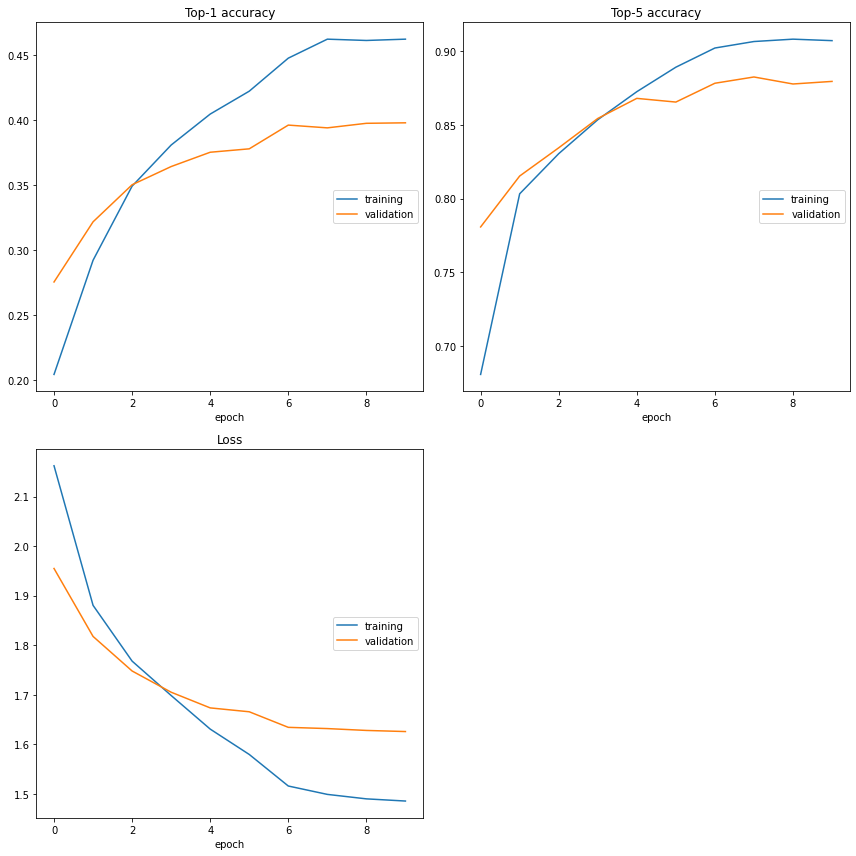

Top-1 accuracy
	training         	 (min:    0.204, max:    0.462, cur:    0.462)
	validation       	 (min:    0.276, max:    0.398, cur:    0.398)
Top-5 accuracy
	training         	 (min:    0.681, max:    0.908, cur:    0.907)
	validation       	 (min:    0.781, max:    0.882, cur:    0.879)
Loss
	training         	 (min:    1.486, max:    2.162, cur:    1.486)
	validation       	 (min:    1.626, max:    1.955, cur:    1.626)
Train Loss: 1.4859 Top-1 Acc: 0.4622 Top-5 Acc: 0.9070
Val Loss: 1.6260 Top-1 Acc: 0.3979 Top-5 Acc: 0.8794
Best Val Top-5 Accuracy: 0.882375

Training complete in 1m 40s
Best val Top-5 Acc: 0.882375


In [ ]:
#Train
model_classifier_trained, train_loss, test_loss, train_acc_top1, test_acc_top1, train_acc_top5, test_acc_top5  = train_classifier(model_classifier, dataloaders, dataset_sizes, criterion, optimizer, exp_lr_scheduler, DEVICE, NUM_EPOCHS)

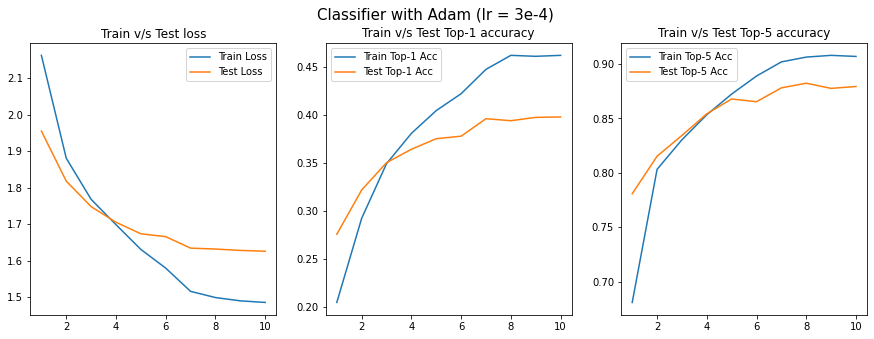

In [ ]:
epochs = [x for x in range(1, 11)]

fig, axs = plt.subplots(1, 3, figsize=(15,5))
axs[0].plot(epochs, train_loss, label='Train Loss')
axs[0].plot(epochs, test_loss, label='Test Loss')
axs[0].set_title('Train v/s Test loss')
axs[0].legend()

axs[1].plot(epochs, train_acc_top1, label='Train Top-1 Acc')
axs[1].plot(epochs, test_acc_top1, label='Test Top-1 Acc')
axs[1].set_title('Train v/s Test Top-1 accuracy')
axs[1].legend()

axs[2].plot(epochs, train_acc_top5, label='Train Top-5 Acc')
axs[2].plot(epochs, test_acc_top5, label='Test Top-5 Acc')
axs[2].set_title('Train v/s Test Top-5 accuracy')
axs[2].legend()

fig.suptitle('Classifier with Adam (lr = 3e-4)', fontsize = 15)
plt.show()


In [ ]:
from sklearn.metrics import classification_report

In [ ]:
def evaluate(model, test_loader):
    model.eval()  # set the model to evaluation mode
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.view(-1, 3*96*96)
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, predicted = torch.max(outputs, dim=1)
            y_true.append(labels.cpu().numpy())
            y_pred.append(predicted.cpu().numpy())

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    classwise_accuracy = []
    for i in range(10):
        indices = np.where(y_true == i)[0]
        accuracy = np.mean(y_pred[indices] == y_true[indices])
        classwise_accuracy.append(accuracy)

    print("Classwise Accuracies:")
    for i, accuracy in enumerate(classwise_accuracy):
        print(f"Class {i}: {accuracy}")

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

evaluate(model_classifier, test_loader)

Classwise Accuracies:
Class 0: 0.54375
Class 1: 0.29625
Class 2: 0.61625
Class 3: 0.185
Class 4: 0.37375
Class 5: 0.14375
Class 6: 0.42125
Class 7: 0.3875
Class 8: 0.59125
Class 9: 0.38125

Classfication Report:
              precision    recall  f1-score   support

           0       0.59      0.54      0.57       800
           1       0.33      0.30      0.31       800
           2       0.49      0.62      0.55       800
           3       0.23      0.18      0.21       800
           4       0.32      0.37      0.34       800
           5       0.22      0.14      0.17       800
           6       0.37      0.42      0.39       800
           7       0.31      0.39      0.35       800
           8       0.58      0.59      0.58       800
           9       0.43      0.38      0.40       800

    accuracy                           0.39      8000
   macro avg       0.39      0.39      0.39      8000
weighted avg       0.39      0.39      0.39      8000



Using Hook to get output of a particular layer

In [ ]:
model_classifier.layers[6]

Linear(in_features=728, out_features=512, bias=True)

In [ ]:
# define a list to store the outputs of the desired layer

# define a function that will be called when the desired layer is evaluated
embeddings = []
def get_layer_outputs(module, input, output):
    # print(output.shape)
    embeddings.append(output)

# register the forward hook for the desired layer
hook_handle = model_classifier.layers[6].register_forward_hook(get_layer_outputs)

lt_embed = []
lt_lb = []
with torch.no_grad():
  model_classifier.eval()
  for images, labels in test_loader:
    embeddings = []
    # move the data to the GPU if available
    images = images.to(DEVICE)
    images = images.view(-1, 3*96*96)
    # forward pass
    outputs = model_classifier(images)

    # for tsne plots - 6th Layer outputs
    # break
    lt_embed.append(torch.from_numpy(embeddings[6]))
    lt_lb.append(labels)
    print(type(embeddings[6]))
    print(embeddings[6].shape)
    print("\n\n\n\n")

embed_tensor = torch.cat(lt_embed)
label_tensor = torch.cat(lt_lb)

# remove the hook
hook_handle.remove()

torch.Size([100, 512])
torch.Size([100, 512])
<class 'numpy.ndarray'>
(100, 512)





torch.Size([100, 512])
torch.Size([100, 512])
<class 'numpy.ndarray'>
(100, 512)





torch.Size([100, 512])
torch.Size([100, 512])
<class 'numpy.ndarray'>
(100, 512)





torch.Size([100, 512])
torch.Size([100, 512])
<class 'numpy.ndarray'>
(100, 512)





torch.Size([100, 512])
torch.Size([100, 512])
<class 'numpy.ndarray'>
(100, 512)





torch.Size([100, 512])
torch.Size([100, 512])
<class 'numpy.ndarray'>
(100, 512)





torch.Size([100, 512])
torch.Size([100, 512])
<class 'numpy.ndarray'>
(100, 512)





torch.Size([100, 512])
torch.Size([100, 512])
<class 'numpy.ndarray'>
(100, 512)





torch.Size([100, 512])
torch.Size([100, 512])
<class 'numpy.ndarray'>
(100, 512)





torch.Size([100, 512])
torch.Size([100, 512])
<class 'numpy.ndarray'>
(100, 512)





torch.Size([100, 512])
torch.Size([100, 512])
<class 'numpy.ndarray'>
(100, 512)





torch.Size([100, 512])
torch.Size([100, 512])
<class '

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
tsne = TSNE(n_components=2, random_state=0)

tsne_data = tsne.fit_transform(embed_tensor)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


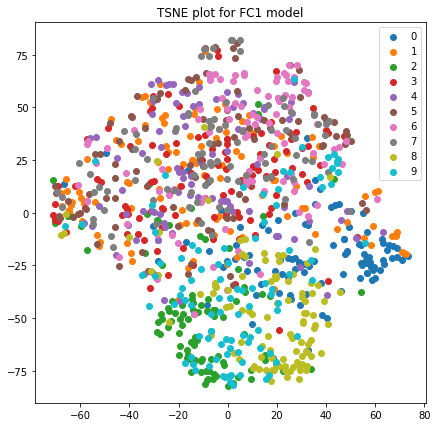

In [ ]:
scatter_x = tsne_data[:5000,0]
scatter_y = tsne_data[:5000,1]
group = label_tensor[:1000]

fig, ax = plt.subplots(figsize=(7, 7))
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix],  label = g)
ax.legend()
plt.title('TSNE plot for FC1 model')
plt.show()
